In [1]:
from space_exploration.beans.training_bean import Training
from space_exploration.beans.dataset_bean import Dataset
from space_exploration.training.training import ModelTraining
from space_exploration.dataset.transforms.AllTransforms import TransformationReferences

In [2]:
dataset_name = "re200-sr1etot"
# dataset_name = "prediction-a67107ff6b9c4ab6ad48546e70384b88"
dataset = Dataset.get_dataset_or_fail(dataset_name)

In [3]:
ds = dataset.get_training_dataset(64, TransformationReferences.DEFAULT_UNCHANGED.transformation, TransformationReferences.DEFAULT_UNCHANGED.transformation, size=300)

⌛ Initializing Dataset...
X...
[########################################] | 100% Completed | 209.47 ms
Y...
[########################################] | 100% Completed | 2.79 ss


In [4]:
xs = [x for x, y in ds]
ys = [y for x, y in ds]

In [5]:
x = xs[0].numpy()
y = ys[0].numpy()

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def get_img(x, component=None):
    if component is None:
        image = np.transpose(x, axes=(1, 2, 3, 0))[:, 0, :, :]
    else:
        image = x[component, :, 0, :]
    return image

def center_img(image):
    image = image / (image.max() - image.min())
    image = image - image.min()
    return image

def show_img(image):
    plt.imshow(image)
    plt.show()
    
def show_x(x, component=None):
    image = get_img(x, component)
    image = center_img(image)
    show_img(image)

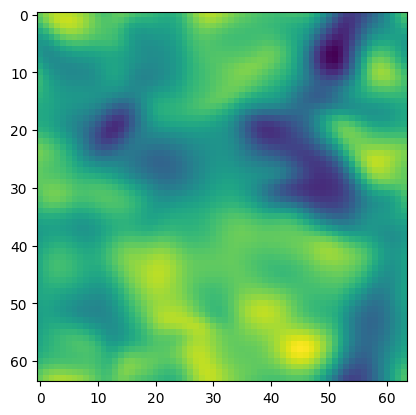

In [7]:
show_x(x, 0)

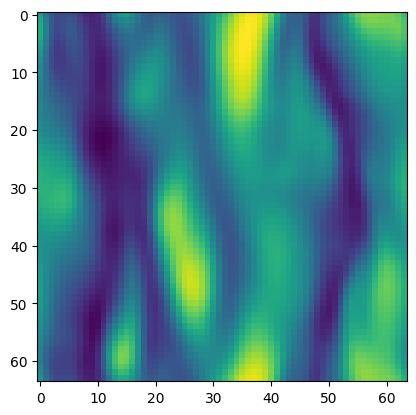

In [8]:
show_x(x, 1)

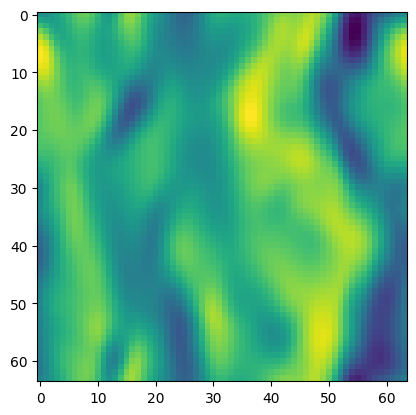

In [9]:
show_x(x, 2)

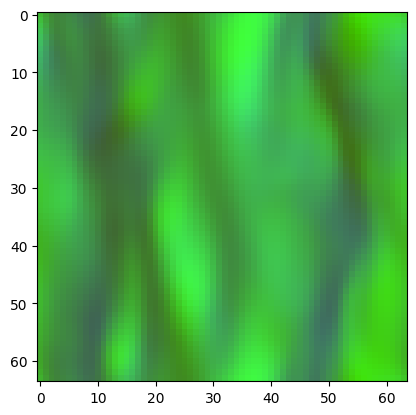

In [10]:
show_x(x)

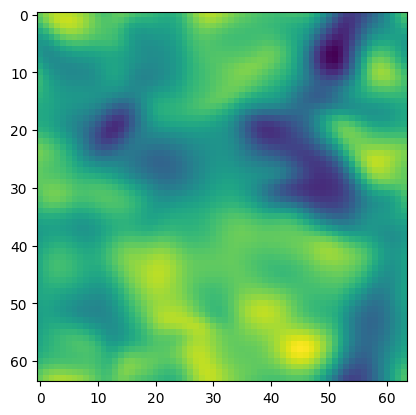

In [11]:
from scipy.ndimage import gaussian_filter

image = get_img(x, 0)
show_img(image)
smoothed = gaussian_filter(image, sigma=2)


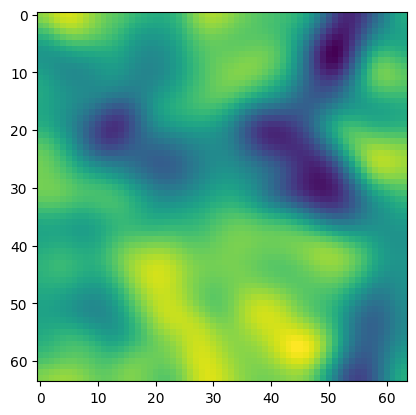

In [12]:
show_img(smoothed)


In [13]:
# image = image.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
import cv2
blur1 = cv2.GaussianBlur(image, (0, 0), sigmaX=3)
blur2 = cv2.GaussianBlur(image, (0, 0), sigmaX=5)
dog = blur1 - blur2

In [ ]:
show_img(dog)

In [ ]:
from skimage.feature import blob_dog
blobs = blob_dog(image, max_sigma=5, threshold=0.00)

In [ ]:
blobs.shape

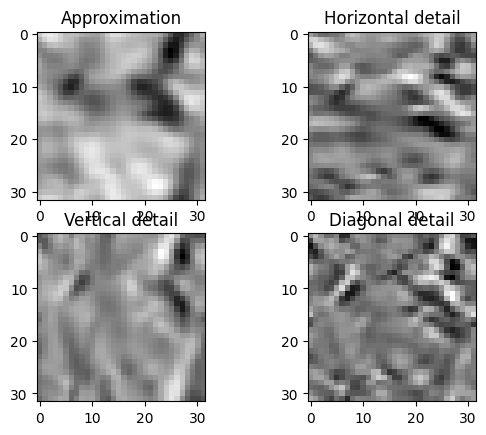

In [14]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

coeffs = pywt.dwt2(image, 'db1')  # db1 = Daubechies wavelet
cA, (cH, cV, cD) = coeffs

# Show approximation and detail coefficients
plt.subplot(2, 2, 1); plt.imshow(cA, cmap='gray'); plt.title('Approximation')
plt.subplot(2, 2, 2); plt.imshow(cH, cmap='gray'); plt.title('Horizontal detail')
plt.subplot(2, 2, 3); plt.imshow(cV, cmap='gray'); plt.title('Vertical detail')
plt.subplot(2, 2, 4); plt.imshow(cD, cmap='gray'); plt.title('Diagonal detail')
plt.show()

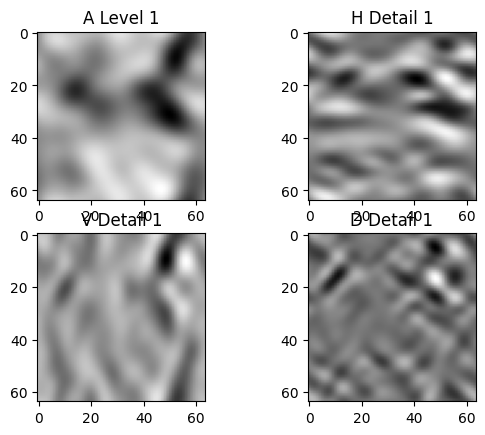

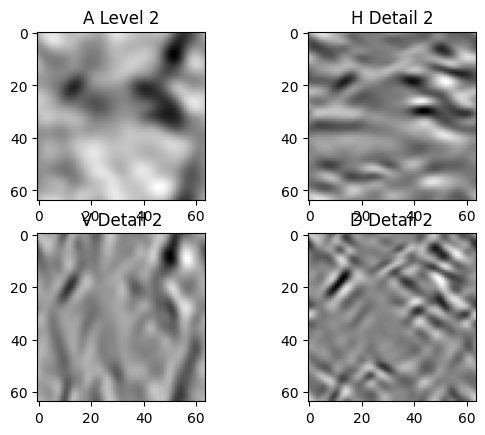

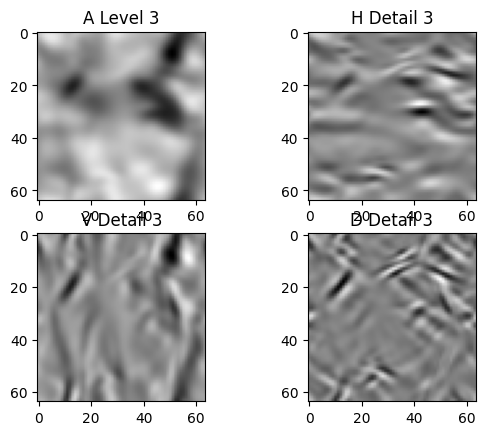

In [15]:
import pywt

coeffs = pywt.swt2(image, wavelet='db2', level=3)
for i, (cA, (cH, cV, cD)) in enumerate(coeffs):
    plt.subplot(2, 2, 1); plt.imshow(cA, cmap='gray'); plt.title(f'A Level {i+1}')
    plt.subplot(2, 2, 2); plt.imshow(cH, cmap='gray'); plt.title(f'H Detail {i+1}')
    plt.subplot(2, 2, 3); plt.imshow(cV, cmap='gray'); plt.title(f'V Detail {i+1}')
    plt.subplot(2, 2, 4); plt.imshow(cD, cmap='gray'); plt.title(f'D Detail {i+1}')
    plt.show()

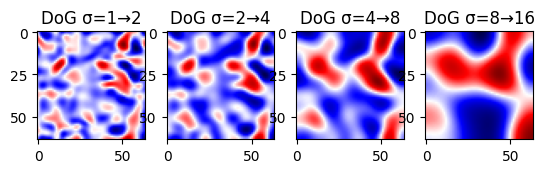

In [16]:
from scipy.ndimage import gaussian_filter

sigmas = [1, 2, 4, 8, 16]
images = [gaussian_filter(image, sigma=s) for s in sigmas]
dog = [images[i+1] - images[i] for i in range(len(images)-1)]

for i, d in enumerate(dog):
    plt.subplot(1, len(dog), i+1)
    plt.imshow(d, cmap='seismic')
    plt.title(f"DoG σ={sigmas[i]}→{sigmas[i+1]}")
plt.show()

2025-07-10 13:25:41.634 ( 107.651s) [    1469137C91C0]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


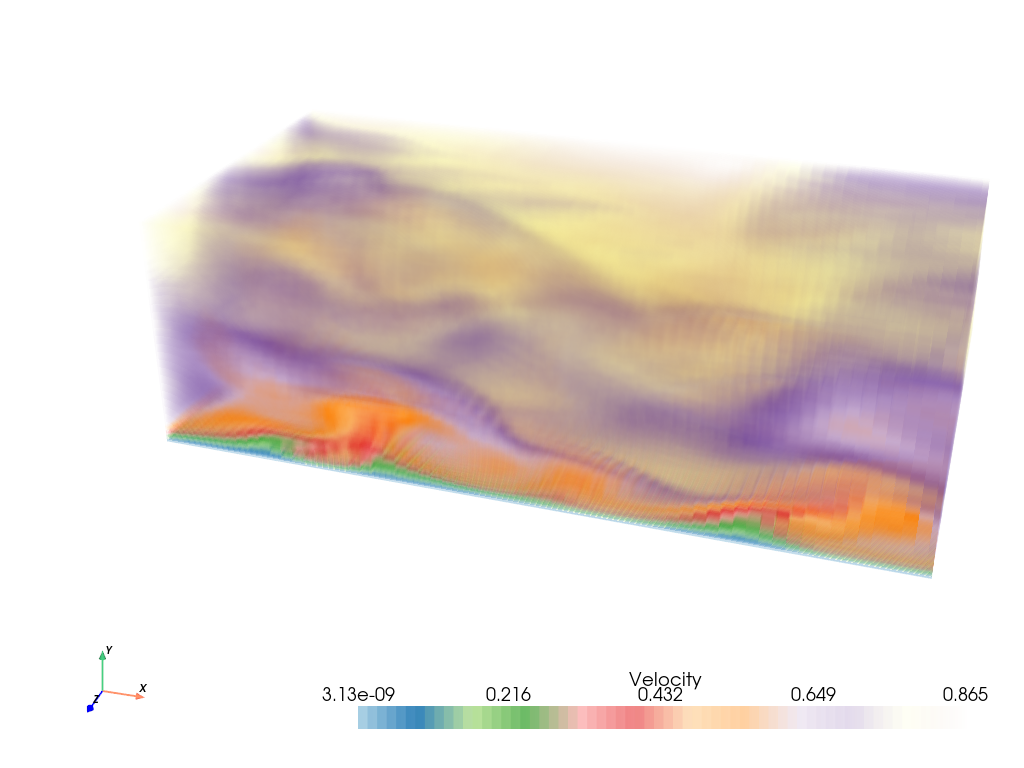

In [17]:
import pyvista as pv
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

pv.set_jupyter_backend('static')

def plot_utils(plotter):
    plotter.camera_position = [
    (3, 3, 6),  # camera position
    (0, -2, -3),     # focal point
    (0, 1, 0),     # up direction → Y is up
    ]
    plotter.show_axes()
    plotter.disable_shadows()
    plotter.show()

def get_grid(dataset, y_lim):
    subspace = dataset.channel.get_simulation_channel()
    grid = pv.RectilinearGrid(subspace.x_dimension, subspace.y_dimension[:y_lim], subspace.z_dimension)
    return grid

grid = get_grid(dataset, 64)

# grid["velocity U"] = y[0, ...].flatten()
# grid["velocity V"] = y[1, ...].flatten()
# grid["velocity W"] = y[2, ...].flatten()

velocity_norm = np.linalg.norm(y, axis=(0))
grid["Velocity"] = velocity_norm.flatten()

plotter = pv.Plotter(notebook=True)
opacity = [0.8, 0.1, 0.3]

paired = plt.get_cmap("Paired")
colors = [paired(i) for i in range(paired.N)]
smooth_custom = LinearSegmentedColormap.from_list("SmoothCustom", colors, N=64)
plotter.add_volume(grid, opacity="linear_r", scalars="Velocity", cmap=smooth_custom)
plot_utils(plotter)


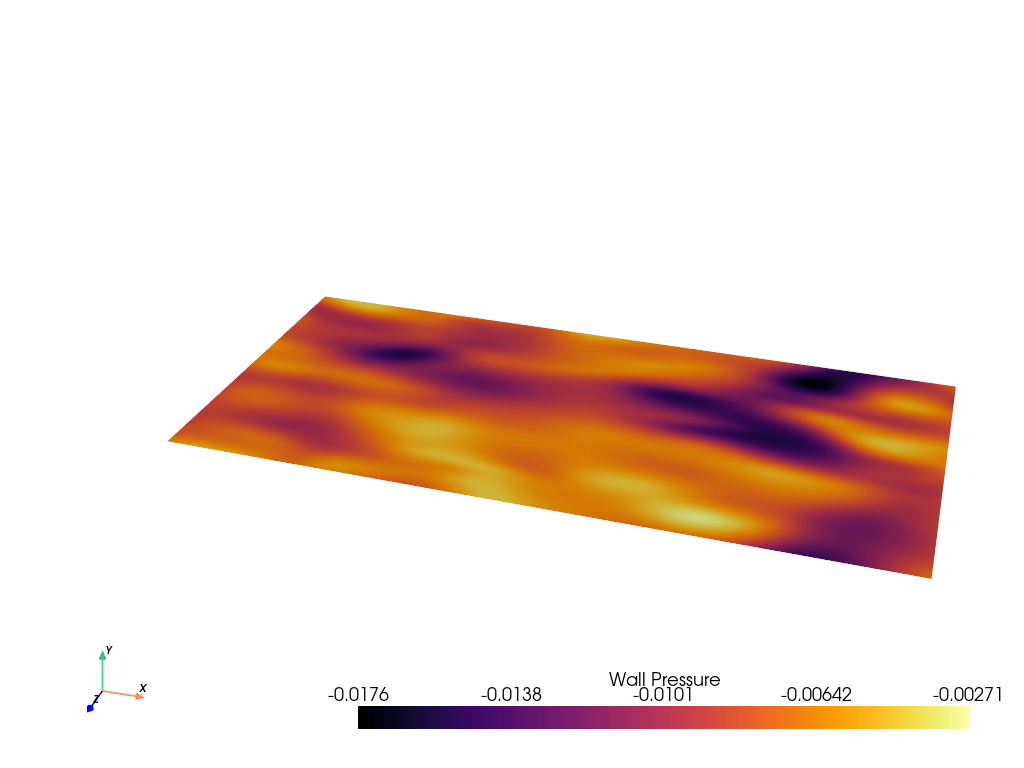

In [18]:

grid = get_grid(dataset, 1)
grid["Wall Pressure"] = x[0, ...].flatten()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid, cmap="inferno")
plot_utils(plotter)


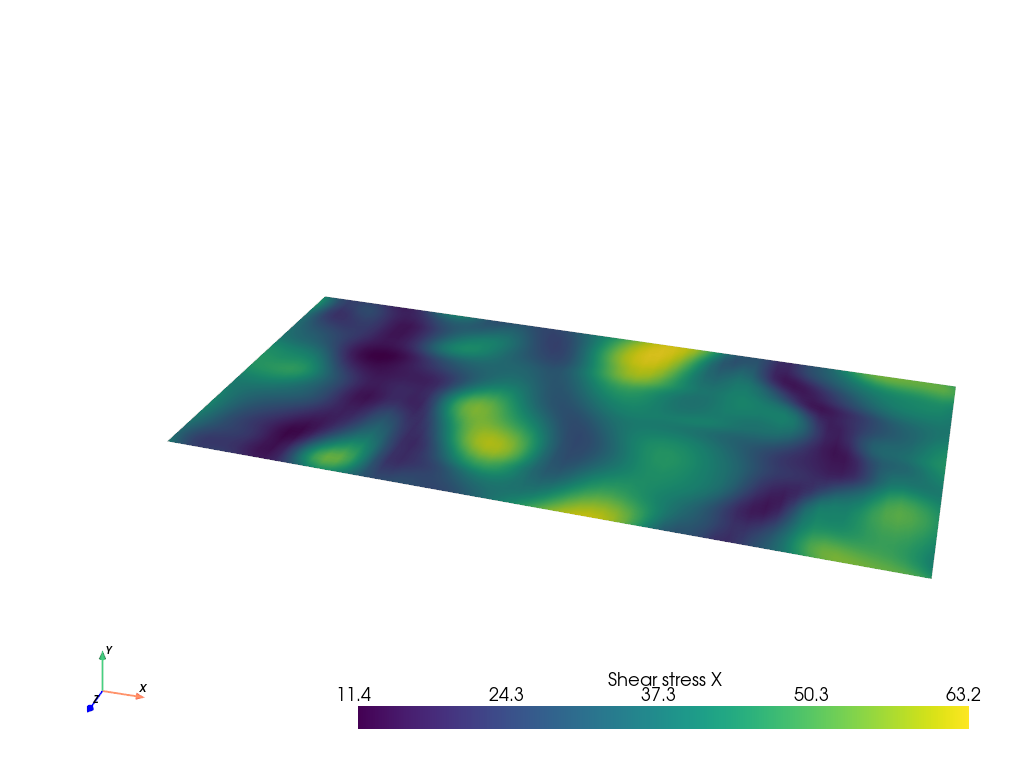

In [19]:
grid = get_grid(dataset, 1)
grid["Shear stress X"] = x[1, ...].flatten()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid, cmap="viridis")
plot_utils(plotter)

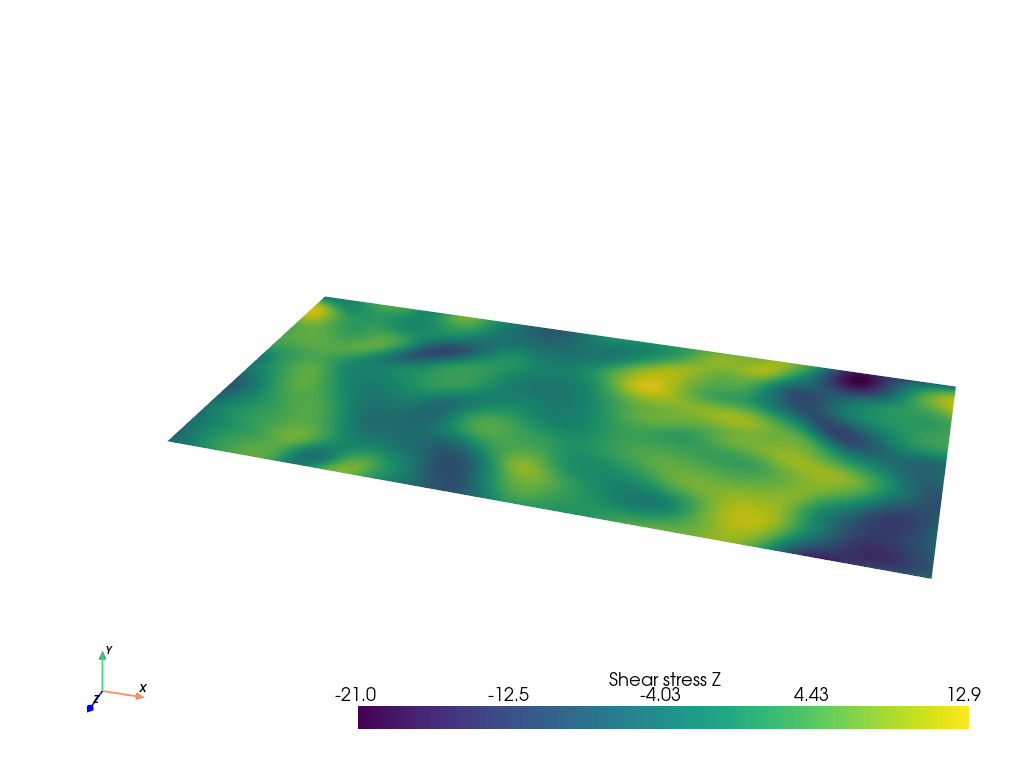

In [20]:
grid = get_grid(dataset, 1)
grid["Shear stress Z"] = x[2, ...].flatten()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid)
plot_utils(plotter)

In [21]:
# Assume y.shape == (3, 64, 64, 64)
u, v, w = y[0], y[1], y[2]

# Compute KE
KE = 0.5 * (u**2 + v**2 + w**2)

In [22]:
from scipy.ndimage import gaussian_laplace
log_filtered = gaussian_laplace(KE, sigma=2.0)

In [23]:
KE = log_filtered

In [24]:

from scipy.ndimage import label

threshold = (KE > 0.0)  # adjust as needed
labeled, num_features = label(threshold)

In [25]:
num_features

5

In [26]:
labeled.shape

(64, 64, 64)

In [27]:
print("KE min:", KE.min(), "KE max:", KE.max())

KE min: -0.014586791 KE max: 0.018317694


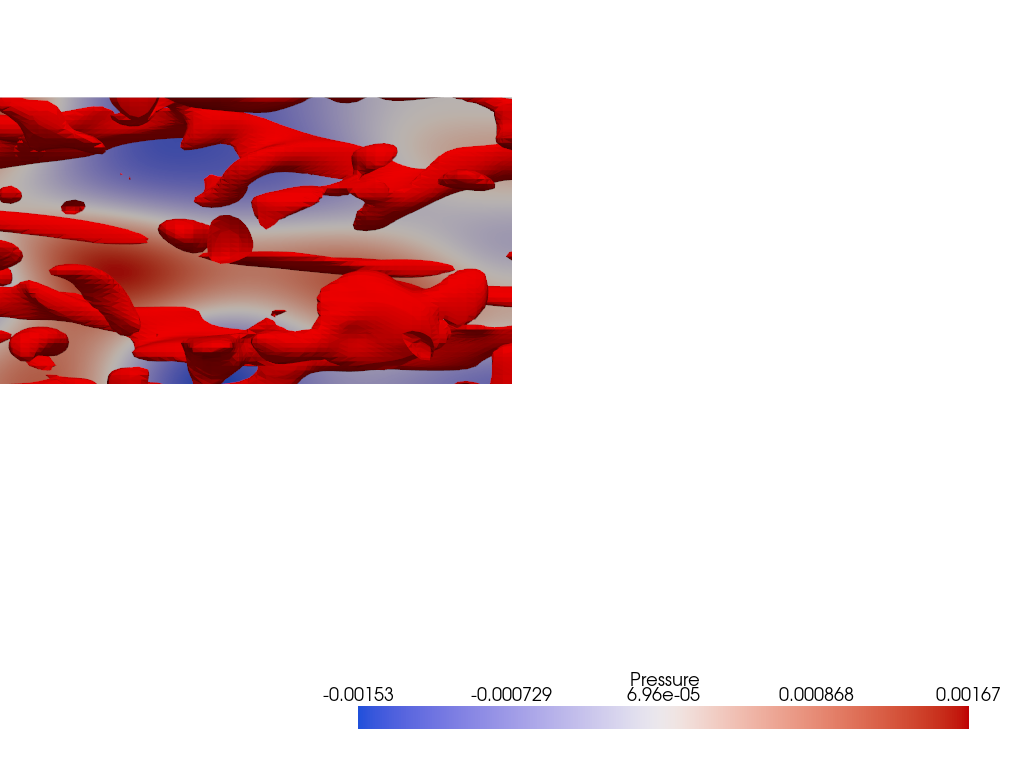

In [28]:
grid = get_grid(dataset, 64)
grid.point_data["KE"] = KE.ravel(order="F")

contour = grid.contour([0.005])  # Iso-surface at KE = 0.5
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(contour, color="red")
# plotter.add_volume(grid, scalars="KE", cmap="coolwarm", opacity=[0.1, 0.1, 0., 0.5])

pressure_plane = get_grid(dataset, 1)
pressure_plane["Pressure"] = dog[3].flatten()
plotter.add_mesh(pressure_plane, cmap="coolwarm")

# plot_utils(plotter)
plotter.camera_position = [
    (0, 8, 0),  # camera position
    (0, 0, 0),     # focal point
    (0, 0, 1),     # up direction → Y is up
    ]
plotter.enable_parallel_projection()
plotter.show()

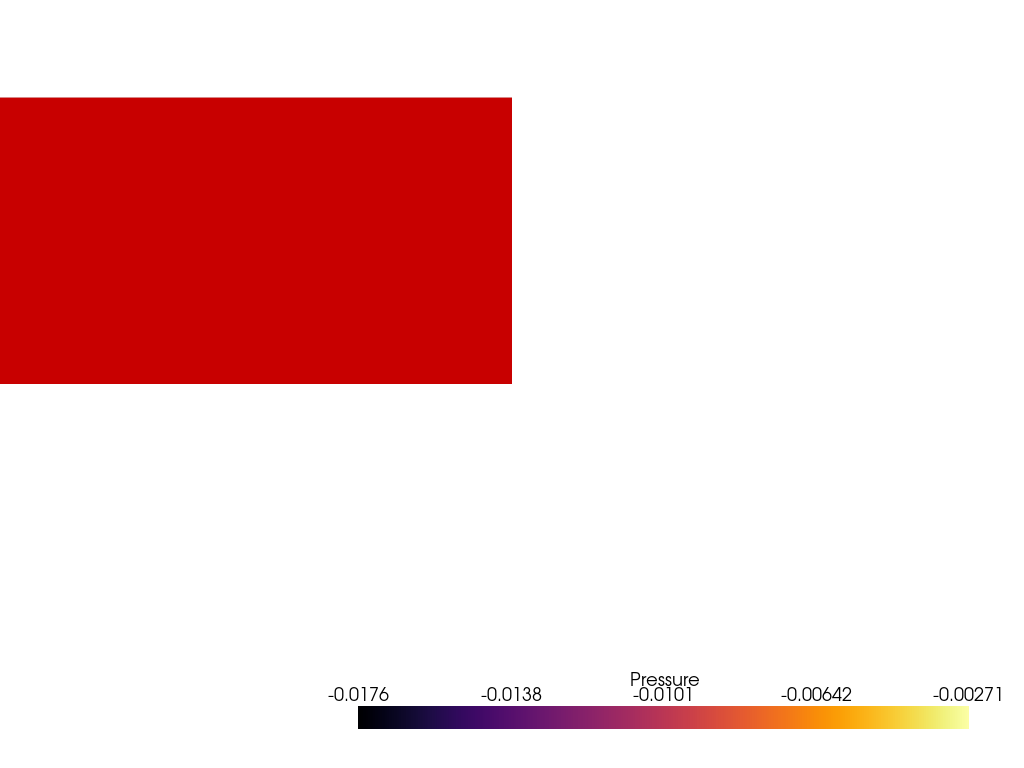

In [29]:
grid = get_grid(dataset, 64)
grid.point_data["KE"] = KE.ravel(order="F")

contour = grid.contour([0.5])  # Iso-surface at KE = 0.5
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid, color="red")

pressure_plane = get_grid(dataset, 1)
pressure_plane["Pressure"] = x[0, ...].flatten()
plotter.add_mesh(pressure_plane, cmap="inferno")

# plot_utils(plotter)
plotter.camera_position = [
    (0, 8, 0),  # camera position
    (0, 0, 0),     # focal point
    (0, 0, 1),     # up direction → Y is up
    ]
plotter.enable_parallel_projection()
plotter.show()

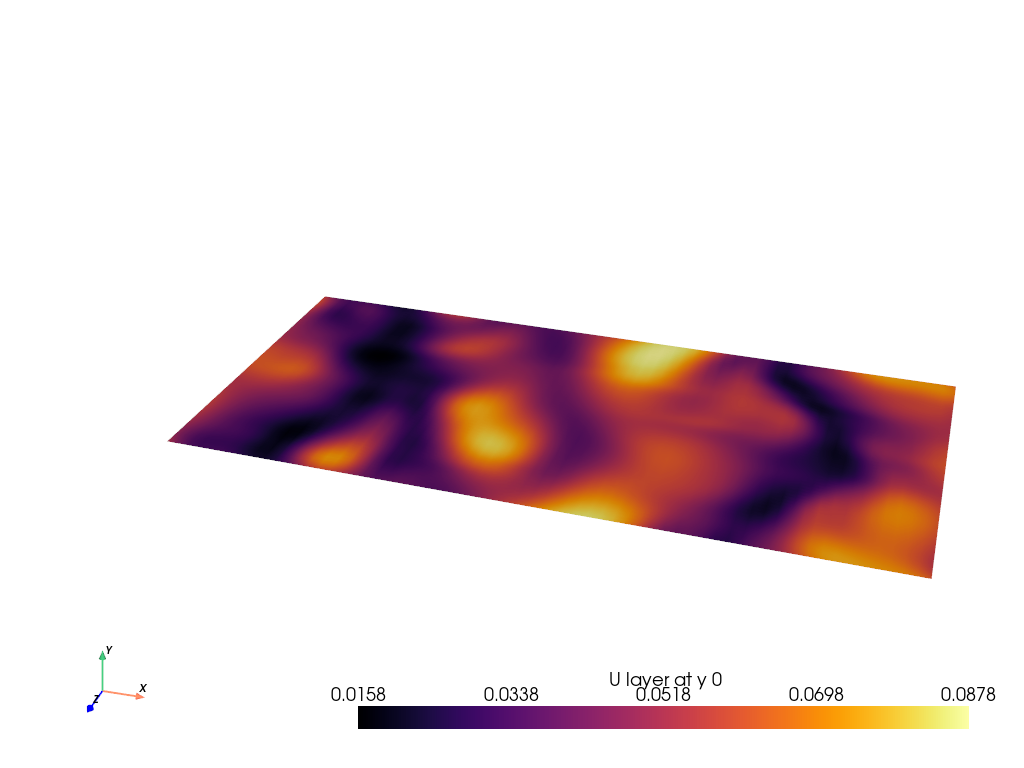

In [40]:

grid = get_grid(dataset, 1)
grid["U layer at y 0"] = y[0, :, 1, :].flatten()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid, cmap="inferno")
plot_utils(plotter)


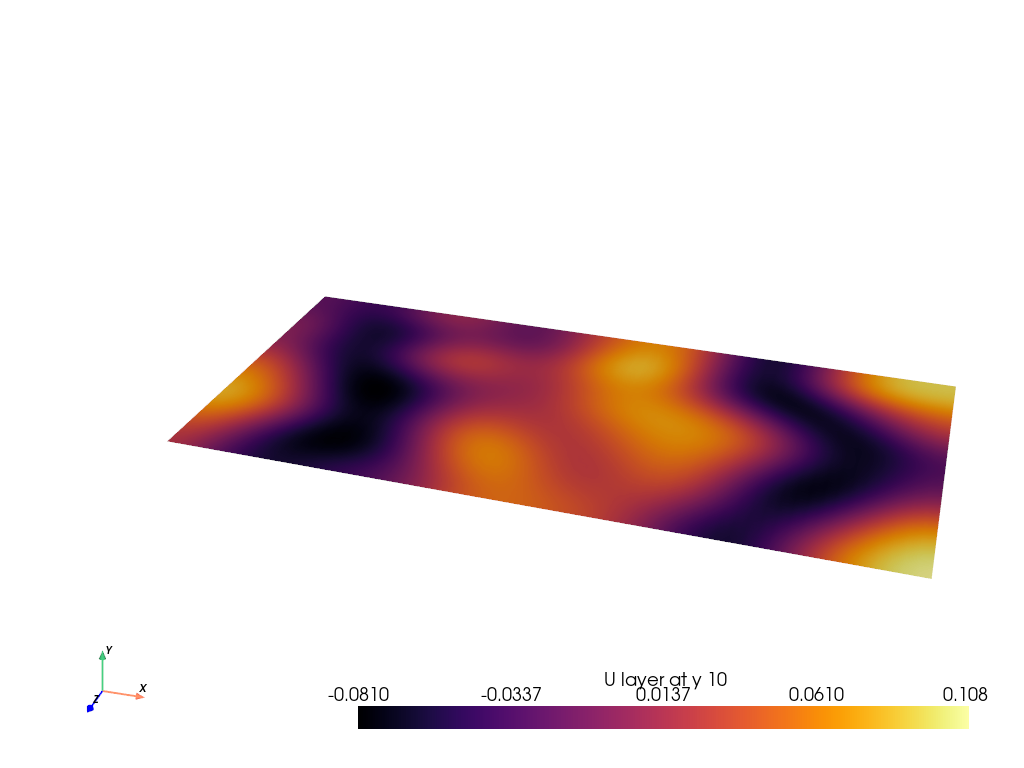

In [41]:

grid = get_grid(dataset, 1)
layer_index = 10
layer = y[0, :, layer_index, :]

layer = gaussian_filter(layer, 5) - gaussian_filter(layer, 15)

grid[f"U layer at y {layer_index}"] = layer.flatten()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid, cmap="inferno")
plot_utils(plotter)

In [31]:
import numpy as np


p3d = np.repeat(x[0, :, :], KE.shape[1], axis=1)

In [32]:
p3d.shape

(64, 64, 64)

In [33]:
from scipy.stats import pearsonr

# Flatten all spatial locations to vectors
u_flat = KE.reshape(-1)
p_flat = p3d.reshape(-1)

# Correlation across all space
r, _ = pearsonr(u_flat, p_flat)
print(f"Overall correlation: {r:.3f}")

Overall correlation: -0.031


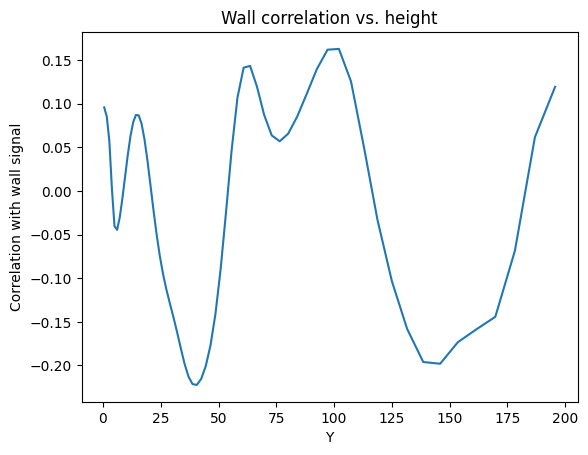

In [34]:
correlation_y = []

for j in range(u.shape[1]):  # Loop over Y
    u_slice = KE[:, j, :]     # shape (Nx, Nz)
    r, _ = pearsonr(u_slice.ravel(), x[0].ravel())
    correlation_y.append(r)

# Now plot correlation_y vs Y
import matplotlib.pyplot as plt
plt.plot(dataset.channel.get_simulation_channel().y_dimension[:64] * 200, correlation_y)
plt.xlabel('Y')
plt.ylabel('Correlation with wall signal')
plt.title('Wall correlation vs. height')
plt.show()

In [35]:
from scipy.stats import pearsonr

def get_correlation(image_batch, field_batch):

    batch_correlations = []
    for image, field in zip(image_batch, field_batch):
        correlations = []
        for velocity_slice in field:
            r, _ = pearsonr(velocity_slice, image)
            rs.append(r)
        batch_correlations.append(correlations)

    return np.mean(batch_correlations, axis=(0))